<a href="https://colab.research.google.com/github/HaAdam1/K05_2Dto3D/blob/base/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Néha valamiért ezek nélkül nem fut le egyszerűen, pedig alapvetően ezek részei a colabnak
!pip install pydicom
!pip install dicom
!pip install plotly
!pip install scikit-image

     |████████████████████████████████| 1.9MB 7.7MB/s 
     |████████████████████████████████| 768kB 9.1MB/s 


In [18]:
#Az egész futtatáshoz szükséges könyvtárak
import pydicom
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import version
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import figure_factory as FF
from plotly.graph_objs import *

In [6]:
data_path = "/content/Crane_spc/"
output_path = working_path = "/content/Output/"
g = glob(data_path + '/*.dcm')

# Egy gyors check 
print ("Number of DICOM files read: %d \nFirst 5 DICOM filename:" % len(g))
print ('\n'.join(g[:5]))

Number of DICOM files read: 142 
First 5 DICOM filename:
/content/Crane_spc/1.3.6.1.4.1.5962.99.1.2786334768.1849416866.1385765836848.89.0.dcm
/content/Crane_spc/1.3.6.1.4.1.5962.99.1.2786334768.1849416866.1385765836848.31.0.dcm
/content/Crane_spc/1.3.6.1.4.1.5962.99.1.2786334768.1849416866.1385765836848.34.0.dcm
/content/Crane_spc/1.3.6.1.4.1.5962.99.1.2786334768.1849416866.1385765836848.40.0.dcm
/content/Crane_spc/1.3.6.1.4.1.5962.99.1.2786334768.1849416866.1385765836848.13.0.dcm


In [8]:
   
# Elsőként definiálunk egy betöltési ciklust, ami minden DICOM szeletet beolvas egy listába

def load_scan(path):
  slices = [pydicom.read_file(path + '/' + s, force=True) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.InstanceNumber))
  try:
      slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
      slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

  for s in slices:
      s.SliceThickness = slice_thickness

  return slices
def get_pixels_hu(scans):
  image = np.stack([s.pixel_array for s in scans])
# Egységes formátumba konvertálás (int16)
  image = image.astype(np.int16)

# a nem hasznos pixeleket 1-re, levegő 0 intenzitás, hasznos -1024, 
  image[image == -2000] = 0

# Hounsfield értékre konvertálás
  intercept = scans[0].RescaleIntercept
  slope = scans[0].RescaleSlope

  if slope != 1:
      image = slope * image.astype(np.float64)
      image = image.astype(np.int16)

  image += np.int16(intercept)

  return np.array(image, dtype=np.int16)
id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
#Feldolgozott adatok kimentése
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

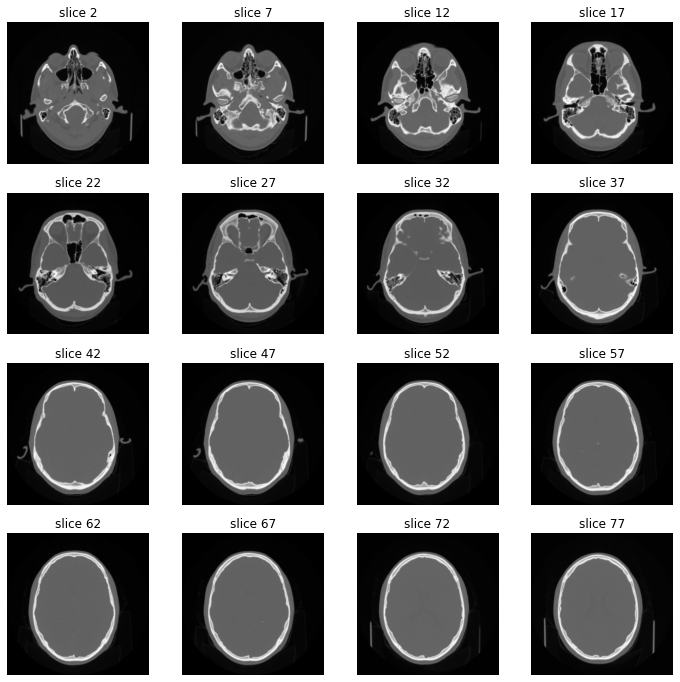

Slice Thickness: 1.000000
Pixel Spacing (row, col): (0.488281, 0.488281) 


In [9]:
#Nézzünk bele a szeletekbe, hogy mindent megfelelően csináltunk-e eddig
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=4, cols=4, start_with=2, show_every=5):
  fig,ax = plt.subplots(rows,cols,figsize=[12,12])
  for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
    ax[int(i/rows),int(i % rows)].axis('off')
  plt.show()

sample_stack(imgs_to_process)
#Nézzük meg egy slice és egy voxel pontosan mekkora méretet vesz fel a valóságban, ez alapján a következő cellában skálázás
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

In [10]:
#Újraskálázás
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def resample(image, scan, new_spacing=[1,1,1]):
# A beolvasott szeleteink pixel távolságai
  spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
  spacing = np.array(list(spacing))
#Újraskálázzuk a szeleteket 1x1x1 mm-es térbe
  resize_factor = spacing / new_spacing
  new_real_shape = image.shape * resize_factor
  new_shape = np.round(new_real_shape)
  real_resize_factor = new_shape / image.shape
  new_spacing = spacing / real_resize_factor

  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)

  return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)


Shape before resampling	 (142, 512, 512)
Shape after resampling	 (142, 250, 250)


In [11]:
#Definiáljunk a mesh-t marching_cubes algoritmussal, első input maga a kép, második a threshold értéke, csontokat próbálunk kiszedni elsősorban, harmadik a lépés
def make_mesh(image, threshold=-300, step_size=1):

  print("Transposing surface")
  p = image.transpose(2,1,0)

  print("Calculating surface")
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
  return verts, faces

In [16]:
#Plottolás definiálása, interaktív
def plotly_3d(verts, faces):
  x,y,z = zip(*verts)

  print("Drawing")

  # Egyszínű colormap, nincs szükség különböző színekre
  colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']

  fig = FF.create_trisurf(x=x,
                    y=y, 
                    z=z, 
                    plot_edges=False,
                    colormap=colormap,
                    simplices=faces,
                    backgroundcolor='rgb(64, 64, 64)',
                    title="Interactive Visualization")
  iplot(fig)

In [13]:
#Nem interaktív
def plt_3d(verts, faces):
  print("Drawing")
  x,y,z = zip(*verts)
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
  face_color = [1, 1, 0.9]
  mesh.set_facecolor(face_color)
  ax.add_collection3d(mesh)

  ax.set_xlim(0, max(x))
  ax.set_ylim(0, max(y))
  ax.set_zlim(0, max(z))
  ax.set_facecolor((0.7, 0.7, 0.7))
  plt.show()

Transposing surface
Calculating surface
Drawing


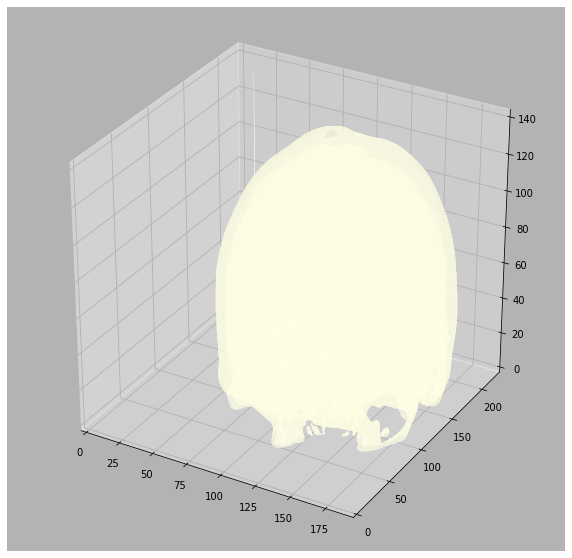

In [14]:
#Végül kiplottoljuk az eredményeket
import plotly.io as pio
pio.renderers.default = "colab"
v, f = make_mesh(imgs_after_resamp, 250)
plt_3d(v, f)

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"
v, f = make_mesh(imgs_after_resamp, 250)
plotly_3d(v, f)

Transposing surface
Calculating surface
Drawing
